# 2D Air Temperature Analysis: Heatmaps
This notebook provides a comprehensive analysis of 2-meter air temperature (ta_2m) from PALM (Potsdam Atmospheric Large-Eddy Simulation Model) 2D output files. It focuses on visualizing spatial temperature distributions and statistical differences between a Baseline simulation scenario and Scenario 1.

* **Data Loading and Preprocessing**: Imports 2D av_xy_N03.000.nc files and static driver data.
* **Variable Selection**: Allows interactive selection of the 2D variable for analysis.
* **Time Series Definition**: Defines time sequences and equivalents for temporal aggregation.
* **Spatial Analysis**: Computes and visualizes mean temperature heatmaps for different periods (day/night) and calculates mean differences between scenarios.
* **Statistical Testing**: Performs independent t-tests at individual pixel levels to identify statistically significant temperature differences.
* **Visualization**: Generates heatmaps to display mean temperatures, mean differences, and t-test results, enhanced with AOI (Area of Interest) overlays and statistical summary tables.

The goal is to provide a detailed spatial and temporal understanding of the impact of Scenario 1 on air temperature, highlighting areas with significant changes.

## 1. Import Dependencies
This section imports all necessary libraries for data manipulation, NetCDF file handling, geographical data processing, statistical analysis, interactive widgets, and advanced plotting capabilities.

In [1]:
import os
import numpy as np
import netCDF4 as nc
import numpy.ma as ma

import geopandas as gpd
import pandas as pd
from scipy import stats

from IPython.display import display
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, MultipleLocator
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap as lsc
from matplotlib.patches import Patch

from utils import palm_variables

## 2. Import Data
This section defines the file paths for the 2D simulation output NetCDF files (for baseline and scenario 1) and the static driver file. These files are then loaded into netCDF4.Dataset objects, making their contents accessible for processing. The buildings_2d data from the static driver is also extracted, which is used for masking non-atmospheric grid cells during data extraction.

In [2]:
# Absolute URLs (paths) of 2D xy-averaged simulation output files and the static driver file.
file_xy_1 = r"./Data/agg_6/konstanz_4096x4096_v9_Baseline_av_xy_N03_ta_2m_xy.nc"
file_xy_2 = r"./Data/agg_6/konstanz_4096x4096_v9_Scenario_1_av_xy_N03_ta_2m_xy.nc"
file_xy_ref = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Baseline-48hr/OUTPUT/konstanz_4096x4096_v9_Baseline_av_xy_N03.000.nc"
file_static = r"./Data/INPUT/konstanz_4096x4096_v9_Baseline_static_N03"

# Read NetCDF files into Dataset objects in read mode ('r').
dataset_1 = nc.Dataset(file_xy_1, mode='r')
dataset_2 = nc.Dataset(file_xy_2, mode='r')
dataset_ref = nc.Dataset(file_xy_ref, mode='r')
dataset_3 = nc.Dataset(file_static, mode='r')

# Store the Dataset objects and their corresponding file paths in lists for easy iteration.
file_xy_list = [file_xy_1, file_xy_2]
dataset_list = [dataset_1, dataset_2]

# Extract 2D buildings data from the static dataset.
# This data is crucial for masking out non-atmospheric grid cells (e.g., inside buildings)
# when performing spatial averages or statistical tests.
buildings_2d = dataset_3['buildings_2d']
buildings_2d_data = buildings_2d[:, :]

## 3. Variable Selection
This section allows the user to interactively select a 2D variable from the loaded NetCDF datasets. A dropdown widget is provided for selection, and the chosen variable's description and unit (retrieved from the palm_variables module) are displayed for clear identification.

In [3]:
# Extract variable names from the first dataset where the number of dimensions is greater than 2.
# In PALM xy-averaged output files, these typically represent 2D spatial data over time (time, y, x).
var_names_palm = [var for var in dataset_1.variables if dataset_1.variables[var].ndim > 2]

# Initialize `test_variable` with the first variable in the list (`var_names_palm[0]`),
# which is commonly 'ta_2m*_xy' for 2-m air temperature.
test_variable = var_names_palm[0]

# Create a dropdown widget to allow the user to select the desired 2D variable.
drop_down = widgets.Dropdown(
    options=var_names_palm,         # Populate the dropdown with the extracted 2D variable names.
    value=var_names_palm[0],        # Set the initial selected value in the dropdown.
    description='Select test variable:' # Label displayed next to the dropdown.
)

# Define a handler function that will be called whenever the dropdown's value changes.
def dropdown_handler(change):
    global test_variable  # Declare `test_variable` as global to modify it.
    test_variable = change.new     # Update the global `test_variable` with the newly selected value.
    print(f"Selected variable: {test_variable}") # Print the newly selected variable to the console.

# Attach the `dropdown_handler` function to observe changes in the 'value' property of the dropdown.
drop_down.observe(dropdown_handler, names='value')

# Display the dropdown widget in the notebook output.
display(drop_down)

Dropdown(description='Select test variable:', options=('ta_2m*_xy',), value='ta_2m*_xy')

In [4]:
# Check if the selected `test_variable` string contains a wildcard character '*'.
# This is common for PALM variables indicating an xy-averaged or general 2D field.
if "*" in test_variable:
    # If a wildcard is present, extract the base part of the variable name (e.g., 'ta_2m' from 'ta_2m*_xy')
    # and re-append '*' to match the keys in `palm_variables.variables_dict`.
    var_initial = test_variable.split("*")[0] + "*"
    # Retrieve the dictionary of information for `var_initial` from the `palm_variables` module.
    variable_info = palm_variables.variables_dict.get(var_initial, {})
    # Extract the 'unit' from `variable_info`, defaulting to 'No unit available' if the key is missing.
    unit = variable_info.get('unit', 'No unit available')
    # Extract the 'description' from `variable_info`, defaulting to 'No description available' if the key is missing.
    description = variable_info.get('description', 'No description available')
    # Print the capitalized description and its unit.
    print(f"{description.capitalize()}, {unit}")

2-m air temperature, °C


## 4. Define Time Sequences and Equivalents
This section dynamically extracts the total number of time steps from the loaded dataset. It then defines parameters for time step intervals and calculates sequences and human-readable time equivalents (HH:MM format) for both hourly and all time steps. These sequences are crucial for temporal aggregation and plotting.

In [5]:
# Extract `variable_data_1` for the `test_variable` from the first dataset.
variable_data_1 = dataset_1[test_variable]

# Get the shape of `variable_data_1` to determine the total number of time steps.
variable_data_shape = np.shape(variable_data_1)
total_time_steps = variable_data_shape[0] # The first dimension is usually time.

# Define `time_step_interval`: This controls how frequently data points are sampled or aggregated.
# In PALM, each time step typically represents 10 minutes. Here it is set to 6, for hourly data (6 * 10 minutes = 60 minutes).
time_step_interval = 6

# Define `second_step`: This offset helps align `time_sequence_hourly` with actual hour marks.
# If time steps are 0-indexed and represent 10-minute intervals:
#   - `second_step = 0`: Corresponds to 0:00, 0:10, 0:20...
#   - `second_step = 5`: Corresponds to 0:50, 1:50, 2:50... (often used for hourly averages centered at the hour)
second_step = 5

# `time_sequence`: A list of time step indices for hourly intervals.
# It starts at `0` and extends by `time_step_interval` from `second_step`.
time_sequence = [0]
time_sequence.extend(np.arange(second_step, total_time_steps, time_step_interval))

# `time_sequence_all`: A list containing all available time step indices (from 0 to `total_time_steps - 1`).
time_sequence_all = range(total_time_steps)

def get_time_equivalent(time_sequence):
    """
    Converts a sequence of time steps (each representing 10 minutes) into
    human-readable HH:MM format.

    Args:
        time_sequence (list or array): A list of time step indices.

    Returns:
        tuple: A tuple containing:
            - time_equivalent (list): List of time strings in HH:MM format (can exceed 24 hours).
            - time_equivalent_24hr (list): List of time strings in 24-hour HH:MM format (resets after 23:50).
    """
    time_equivalent = []
    time_equivalent_24hr = []
    
    for time_step in time_sequence:
        # Calculate total minutes from the start of the simulation (each step is 10 minutes).
        total_minutes = (time_step + 1) * 10 
        hours, minutes = divmod(total_minutes, 60) # Convert total minutes to hours and remaining minutes.
        
        # Append time equivalent in HH:MM format (hours can exceed 24, e.g., 25:00 for the next day).
        time_equivalent.append(f"{hours:02d}:{minutes:02d}")
        
        # Calculate hours in a 24-hour cycle for `time_equivalent_24hr`.
        hours_24hr = hours % 24 
        time_equivalent_24hr.append(f"{hours_24hr:02d}:{minutes:02d}")
    
    return time_equivalent, time_equivalent_24hr

# Generate time equivalents for hourly and all time steps.
time_equivalent, time_equivalent_24hr = get_time_equivalent(time_sequence)
time_equivalent_all, time_equivalent_all_24hr = get_time_equivalent(time_sequence_all)

## 5. Helper Functions for Spatial Operations and Plotting
This section defines several helper functions crucial for spatial data manipulation and plot customization. These include functions for calculating grid coordinates, adjusting plot ticks, determining the date based on time index, and adding north arrows and scale bars to plots.

In [6]:
# Define grid spacing (dx, dy) from the reference dataset.
# Assuming dx and dy are constant and can be derived from the first two x/y coordinates.
dx = dataset_ref['x'][1] - dataset_ref['x'][0]
dy = dataset_ref['y'][1] - dataset_ref['y'][0]

# Define number of cells in x and y dimensions.
# These are derived from the length of the 'x' and 'y' dimensions in the dataset.
nx = np.shape(dataset_ref['x'])[0]
ny = np.shape(dataset_ref['y'])[0]

# Coordinates of the origin in PALM (origin_x, origin_y, origin_z).
# These represent the real-world (e.g., UTM) coordinates of the southwest corner of the simulation domain.
origin_x, origin_y, origin_z = dataset_ref.origin_x, dataset_ref.origin_y, dataset_ref.origin_z

# Vectors for coordinate at cell edges (x, y).
# These arrays define the real-world coordinates of the grid cell boundaries.
x = np.arange(nx + 1) * dx + origin_x
y = np.arange(ny + 1) * dy + origin_y

# Vectors for coordinates at cell centers (xc, yc).
# These arrays define the real-world coordinates of the center of each grid cell.
xc = np.arange(nx) * dx + origin_x + dx / 2
yc = np.arange(ny) * dy + origin_y + dy / 2

# `origin_time`: The base time for the simulation, typically a string.
origin_time = dataset_ref.origin_time
# `time_step`: The time interval between consecutive simulation output steps, in seconds.
time_step = 600  # Default PALM output time step (10 minutes).
# `nt`: Total number of time steps in the dataset.
nt = np.shape(dataset_ref['time'])[0]

In [7]:
def center_yticks(ax):
    """
    Adjusts the vertical alignment of y-axis tick labels to be centered.

    Args:
        ax (matplotlib.axes.Axes): The axes object of the plot.
    """
    # Get the current y-tick positions and generate corresponding labels.
    tick_positions = ax.get_yticks()
    tick_labels = [f'{pos:.2f}' for pos in tick_positions] # Format to two decimal places.
    
    # Set the tick positions explicitly using `FixedLocator` to prevent Matplotlib from auto-adjusting.
    ax.yaxis.set_major_locator(FixedLocator(tick_positions))
    
    # Set the y-tick labels with centered vertical alignment, and specify rotation and font size.
    ax.set_yticklabels(tick_labels, rotation=90, verticalalignment='center', fontsize=12)

In [8]:
def get_date_day(time_index):
    """
    Determines the simulation day (14 or 15) based on the time index,
    assuming 10-minute time steps where 144 steps represent 24 hours.

    Args:
        time_index (int): The time step index (0-indexed).

    Returns:
        int: The day number (14 for the first 24 hours, 15 for the next).
    """
    # 144 time steps = 144 * 10 minutes = 1440 minutes = 24 hours.
    if time_index < 144:
        return 14 # First day (June 14th)
    else:
        return 15 # Second day (June 15th)

In [9]:
def get_extents(gdf_combined, location_id, increased_distance):
    """
    Calculates the array indices (extents) for a given geographical polygon (AOI)
    with an optional buffer distance.

    Args:
        gdf_combined (geopandas.GeoDataFrame): GeoDataFrame containing all AOI polygons.
        location_id (int): Index of the specific AOI in gdf_combined.
        increased_distance (int): The buffer distance in grid cells to expand the AOI.

    Returns:
        tuple: A tuple (x_low, y_low, x_high, y_high) representing the array indices
               of the bounding box for the buffered AOI, clamped to the simulation domain boundaries.
    """
    # Extract the polygon geometry for the given location ID.
    polygon_aug = gdf_combined.iloc[location_id]
    polygon = polygon.geometry
    min_x, min_y, max_x, max_y = polygon.bounds

    # Convert geographic coordinates to array indices (assuming dx = dy).
    x1 = int((min_x - origin_x) / dx)
    y1 = int((min_y - origin_y) / dy)
    x2 = int((max_x - origin_x) / dx)
    y2 = int((max_y - origin_y) / dy)

    # Calculate half-window for the increased distance.
    half_window = int(increased_distance / 2)

    # Apply the buffer to the extents.
    x_low, x_high = x1 - half_window, x2 + half_window
    y_low, y_high = y1 - half_window, y2 + half_window

    # Clamp the extents to the simulation domain boundaries (0 to nx/ny).
    # Ensures that the extracted region does not go out of bounds of the simulation grid.
    x_low = max(0, x_low)
    y_low = max(0, y_low)
    x_high = min(nx, x_high) # Use nx for x_high boundary.
    y_high = min(ny, y_high) # Use ny for y_high boundary.

    return (x_low, y_low, x_high, y_high)

In [10]:
def plot_north_arrow_and_scale_bar(ax):
    """
    Adds a north arrow and a customizable scale bar to the current matplotlib axes.
    The positions are hardcoded for the specific simulation domain of Konstanz.

    Args:
        ax (matplotlib.axes.Axes): The axes object to add the arrow and scale bar to.
    """
    # Hardcoded top-right coordinates for the north arrow position (adjust as needed for different plots/domains).
    top_right_x = 513390
    top_right_y = 5278890
    
    # Create the north arrow as a FancyArrowPatch.
    arrow = patches.FancyArrowPatch((top_right_x, top_right_y - 40), (top_right_x, top_right_y),
                                    arrowstyle='simple', linewidth=1.5, mutation_scale=25, color='k')
    # Add 'N' text near the arrow.
    ax.text(top_right_x, top_right_y - 50, 'N', fontsize=20, color='k', ha='center', va='center', weight='bold')
    ax.add_patch(arrow)    

    # Hardcoded bottom-right coordinates for the scale bar position.
    scale_bar_x = 513250
    scale_bar_y = 5278410
    
    scale_bar_length_meters = 150  # Total length of the scale bar.
    scale_bar_segment_length = 50  # Length of each alternating black/white segment.
    
    # Create the scale bar as a collection of alternating segments.
    num_segments = int(scale_bar_length_meters / scale_bar_segment_length)
    num_labels = num_segments + 1 # Number of labels (0m, 50m, 100m, 150m).
    segment_width = scale_bar_length_meters / num_segments # Width of each segment.
    
    for i in range(num_segments):
        # Alternate colors for segments.
        if i % 2 == 0:
            segment_color = 'k'  # Black for even segments.
        else:
            segment_color = 'w'  # White for odd segments.
        
        segment_x = scale_bar_x + i * segment_width # X-coordinate for the start of the segment.
        # Create a rectangle patch for each segment.
        scale_bar_segment = patches.Rectangle((segment_x, scale_bar_y), segment_width, 15, linewidth=1, edgecolor='w', facecolor=segment_color)
        ax.add_patch(scale_bar_segment)
    
    # Add labels (0m, 50m, 100m, etc.) to the scale bar.
    for i in range(num_labels):
        scale_bar_label = f'{i*scale_bar_segment_length}m' # Label text.
        text_x = scale_bar_x + scale_bar_segment_length * i # X-coordinate for label.
        text_y = scale_bar_y + 25 # Y-coordinate for label (slightly above the bar).
        
        # Add text label with a white background bbox for visibility.
        ax.text(text_x, text_y, scale_bar_label, fontsize=10, ha='center', color='k', weight='bold',
                bbox=dict(facecolor='white', edgecolor='white', boxstyle='round, pad=0.1'))

## 6. Extract Variable Data and Define Areas of Interest (AOIs)
This section loads the selected variable data from both simulation scenarios and reads shapefiles defining specific Areas of Interest (AOIs). These AOIs will be used to extract relevant data subsets for statistical analysis and comparison. Predefined lists for scenario names and AOI labels are also set up.

In [11]:
# Load `variable_data_1` and `variable_data_2` for the `test_variable` from the respective datasets.
variable_data_1 = dataset_1[test_variable]
variable_data_2 = dataset_2[test_variable]

# Store them in a list for easy iteration.
variable_datas = [variable_data_1, variable_data_2]

# Define names for the simulation scenarios, to be used in labels and legends.
sim_scenarions = ['Baseline (BS)', 'Scenario 1 (S1)']
sim_scene = ['BS', 'S1']

# Define paths to shapefiles containing AOI definitions.
# `shapefile_path_child_ii`: For "Child II" AOIs.
shapefile_path_child_ii = r"./Data/shapefiles/03_AOI_Child_II.shp"
# `shapefile_path_uhi_study`: For Urban Heat Island (UHI) study AOIs.
shapefile_path_uhi_study = r"./Data/shapefiles/UHI_aoi_study_fitted.shp"

# Read the shapefiles into GeoDataFrames.
gdf_child = gpd.read_file(shapefile_path_child_ii)
gdf_uhi = gpd.read_file(shapefile_path_uhi_study)

# Combine the GeoDataFrames into a single GeoDataFrame for unified indexing of all AOIs.
gdf_combined = pd.concat([gdf_child, gdf_uhi], ignore_index=True)

# Define lists of location names and AOI names, corresponding to the combined GeoDataFrame.
# These will be used for labeling plots and tables.
location_name_list = ['Overall', 'Stephansplatz', 'Markstaette', 'Augustinerplatz']
aoi_name_list = ['Overall', 'AOI1', 'AOI2', 'AOI3']

In [12]:
# Initialize global variables to store the overall maximum and minimum values.
# `value_maximum` is set to 0, `value_minimum` is set to a very large number to ensure any real value updates it.
global value_maximum, value_minimum
value_maximum = 0
value_minimum = 999999

# Iterate through all available time steps.
for time_index_test in time_sequence:
    # Extract data for the current time step from `variable_data_1` (Baseline).
    # Assuming `variable_data_1` has dimensions (time, z, y, x) or (time, y, x).
    # If 4D, `[time_index_test, 0, :, :]` extracts the 2D slice at z=0. If 3D, `[time_index_test, :, :]`.\n",
    value_test_1 = variable_data_1[time_index_test, 0, :, :] 
    # Apply the 2D building mask to exclude values within buildings.\n",
    value_test_1.mask = ~buildings_2d_data.mask

    # Extract data for the current time step from `variable_data_2` (Scenario 1).\n",
    value_test_2 = variable_data_2[time_index_test, 0, :, :]
    value_test_2.mask = ~buildings_2d_data.mask

    # Find the maximum and minimum non-masked values for the current time step across both scenarios.\n",
    max_value_test = max(np.nanmax(value_test_1), np.nanmax(value_test_2))
    min_value_test = min(np.nanmin(value_test_1), np.nanmin(value_test_2))

    # Update the global `value_maximum` if the current `max_value_test` is greater.\n",
    if value_maximum <= max_value_test:
        value_maximum = max_value_test
    # Update the global `value_minimum` if the current `min_value_test` is smaller.\n",
    if value_minimum >= min_value_test:
        value_minimum = min_value_test

# Print the final global maximum and minimum values found.\n",
print(f"Overall Maximum Temperature: {value_maximum:.2f}")
print(f"Overall Minimum Temperature: {value_minimum:.2f}")

Overall Maximum Temperature: 34.54
Overall Minimum Temperature: 13.89


## 7. Define Time Periods for Analysis
This section defines specific time periods (day and night) for analysis by identifying their corresponding start and end time steps within the simulation. These time steps are then used to create lists of indices that will be used for aggregating data, allowing for focused analysis of diurnal and nocturnal temperature patterns.

In [13]:
# Define start and end times for 'day' periods across two simulated days.
# These times are used to slice the time series data for day-time analysis.
start_time_day = '12:00'
end_time_day = '18:00'

# Define start and end times for 'night' periods across the first simulated night.
# These times are used for nocturnal analysis.
start_time_night = '21:30'
end_time_night = '29:10' # Note: 29:10 is 05:10 on the second day

# Convert human-readable times to their corresponding time step indices for Day 1.
start_day_1 = time_sequence_all[time_equivalent_all.index(start_time_day)]
end_day_1 = time_sequence_all[time_equivalent_all.index(end_time_day)]

# Convert human-readable times to their corresponding time step indices for Day 2.
# Adding 24 to the hour for Day 2 ensures correct indexing of the extended time equivalent list.
start_day_2 = time_sequence_all[time_equivalent_all.index(f"{int(start_time_day[:2])+24}:{start_time_day[-2:]}")]
end_day_2 = time_sequence_all[time_equivalent_all.index(f"{int(end_time_day[:2])+24}:{end_time_day[-2:]}")]

# Convert human-readable times to their corresponding time step indices for Night 1.
start_night_1 = time_sequence_all[time_equivalent_all.index(start_time_night)]
end_night_1 = time_sequence_all[time_equivalent_all.index(end_time_night)]

# Create lists of time step indices for each defined period.
list_day_1 = list(range(start_day_1, end_day_1 + 1))
list_day_2 = list(range(start_day_2, end_day_2 + 1))
list_night_1 = list(range(start_night_1, end_night_1 + 1))

print(f"Day 1: Start index {start_day_1} (time {time_equivalent_all[start_day_1]}) to end index {end_day_1} (time {time_equivalent_all[end_day_1]})")
print(f"Day 2: Start index {start_day_2} (time {time_equivalent_all[start_day_2]}) to end index {end_day_2} (time {time_equivalent_all[end_day_2]})")
print(f"Night 1: Start index {start_night_1} (time {time_equivalent_all[start_night_1]}) to end index {end_night_1} (time {time_equivalent_all[end_night_1]})")

Day 1: Start index 71 (time 12:00) to end index 107 (time 18:00)
Day 2: Start index 215 (time 36:00) to end index 251 (time 42:00)
Night 1: Start index 128 (time 21:30) to end index 174 (time 29:10)


## 8. Compute Mean Temperature Maps
This section computes 2D mean temperature maps for the defined day and night periods for both the Baseline and Scenario 1 simulations. It iterates through the selected time step lists, extracts the corresponding 2D data slices, masks out building areas, and then calculates the mean temperature for each grid cell across the specified time window. These mean maps are essential for visualizing spatial temperature distributions.

In [14]:
# Initialize lists to store 2D temperature data for specified time periods and scenarios.
# `band_values1` and `band_values2` are assumed to be 3D arrays (time, y, x) or (time, z, y, x).
# `[:, 0, :, :]` is used to select the 2D slice if the data is 4D (e.g., at z=0).
band_values1 = dataset_1[test_variable][:, 0, :, :]
band_values2 = dataset_2[test_variable][:, 0, :, :]

values_temp_day1_bs = []
values_temp_day1_s1 = []

values_temp_day2_bs = []
values_temp_day2_s1 = []

values_temp_night1_bs = []
values_temp_night1_s1 = []

# Extract and append 2D temperature data for Day 1 (Baseline and Scenario 1).
for time_index_temp in list_day_1:
    # `.filled(0)` replaces masked values with 0 before appending. This might affect mean if 0 is a valid temp.
    # A more robust approach for masked data might be to average masked arrays directly.
    values_temp_day1_bs.append(band_values1[time_index_temp, :, :].filled(0))
    values_temp_day1_s1.append(band_values2[time_index_temp, :, :].filled(0))
    
# Extract and append 2D temperature data for Day 2 (Baseline and Scenario 1).
for time_index_temp in list_day_2:
    values_temp_day2_bs.append(band_values1[time_index_temp, :, :].filled(0))
    values_temp_day2_s1.append(band_values2[time_index_temp, :, :].filled(0))

# Extract and append 2D temperature data for Night 1 (Baseline and Scenario 1).
for time_index_temp in list_night_1:
    values_temp_night1_bs.append(band_values1[time_index_temp, :, :].filled(0))
    values_temp_night1_s1.append(band_values2[time_index_temp, :, :].filled(0))

# Convert lists of 2D arrays into 3D NumPy arrays for efficient mean calculation.
values_temp_day1_bs = np.array(values_temp_day1_bs)
values_temp_day1_s1 = np.array(values_temp_day1_s1)

values_temp_day2_bs = np.array(values_temp_day2_bs)
values_temp_day2_s1 = np.array(values_temp_day2_s1)

values_temp_night1_bs = np.array(values_temp_night1_bs)
values_temp_night1_s1 = np.array(values_temp_night1_s1)

# Calculate the mean temperature for each grid cell across the time dimension (axis=0).
mean_values_temp_day1_bs = np.mean(values_temp_day1_bs, axis=0)
mean_values_temp_day1_s1 = np.mean(values_temp_day1_s1, axis=0)

mean_values_temp_day2_bs = np.mean(values_temp_day2_bs, axis=0)
mean_values_temp_day2_s1 = np.mean(values_temp_day2_s1, axis=0)

mean_values_temp_night1_bs = np.mean(values_temp_night1_bs, axis=0)
mean_values_temp_night1_s1 = np.mean(values_temp_night1_s1, axis=0)

## 9. Visualize Mean Temperature Heatmaps
**(Day 1 and Day 2)**

This section generates heatmaps to visualize the mean 2-meter air temperature for both Baseline and Scenario 1 during daytime periods of Day 1 and Day 2. The plots include:

Temperature Heatmaps: Displaying spatial temperature distribution using a turbo colormap.
AOI Overlays: Outlining predefined Areas of Interest (AOIs) with buffers.
Statistical Tables: Summarizing mean temperatures for the overall domain and specific AOIs.
Aesthetic Enhancements: Custom color bars, grid lines, and geographic elements (north arrow, scale bar) for improved interpretation.
The visualizations help to quickly identify hot and cold spots and the general temperature patterns in the simulated domain for each scenario and day.

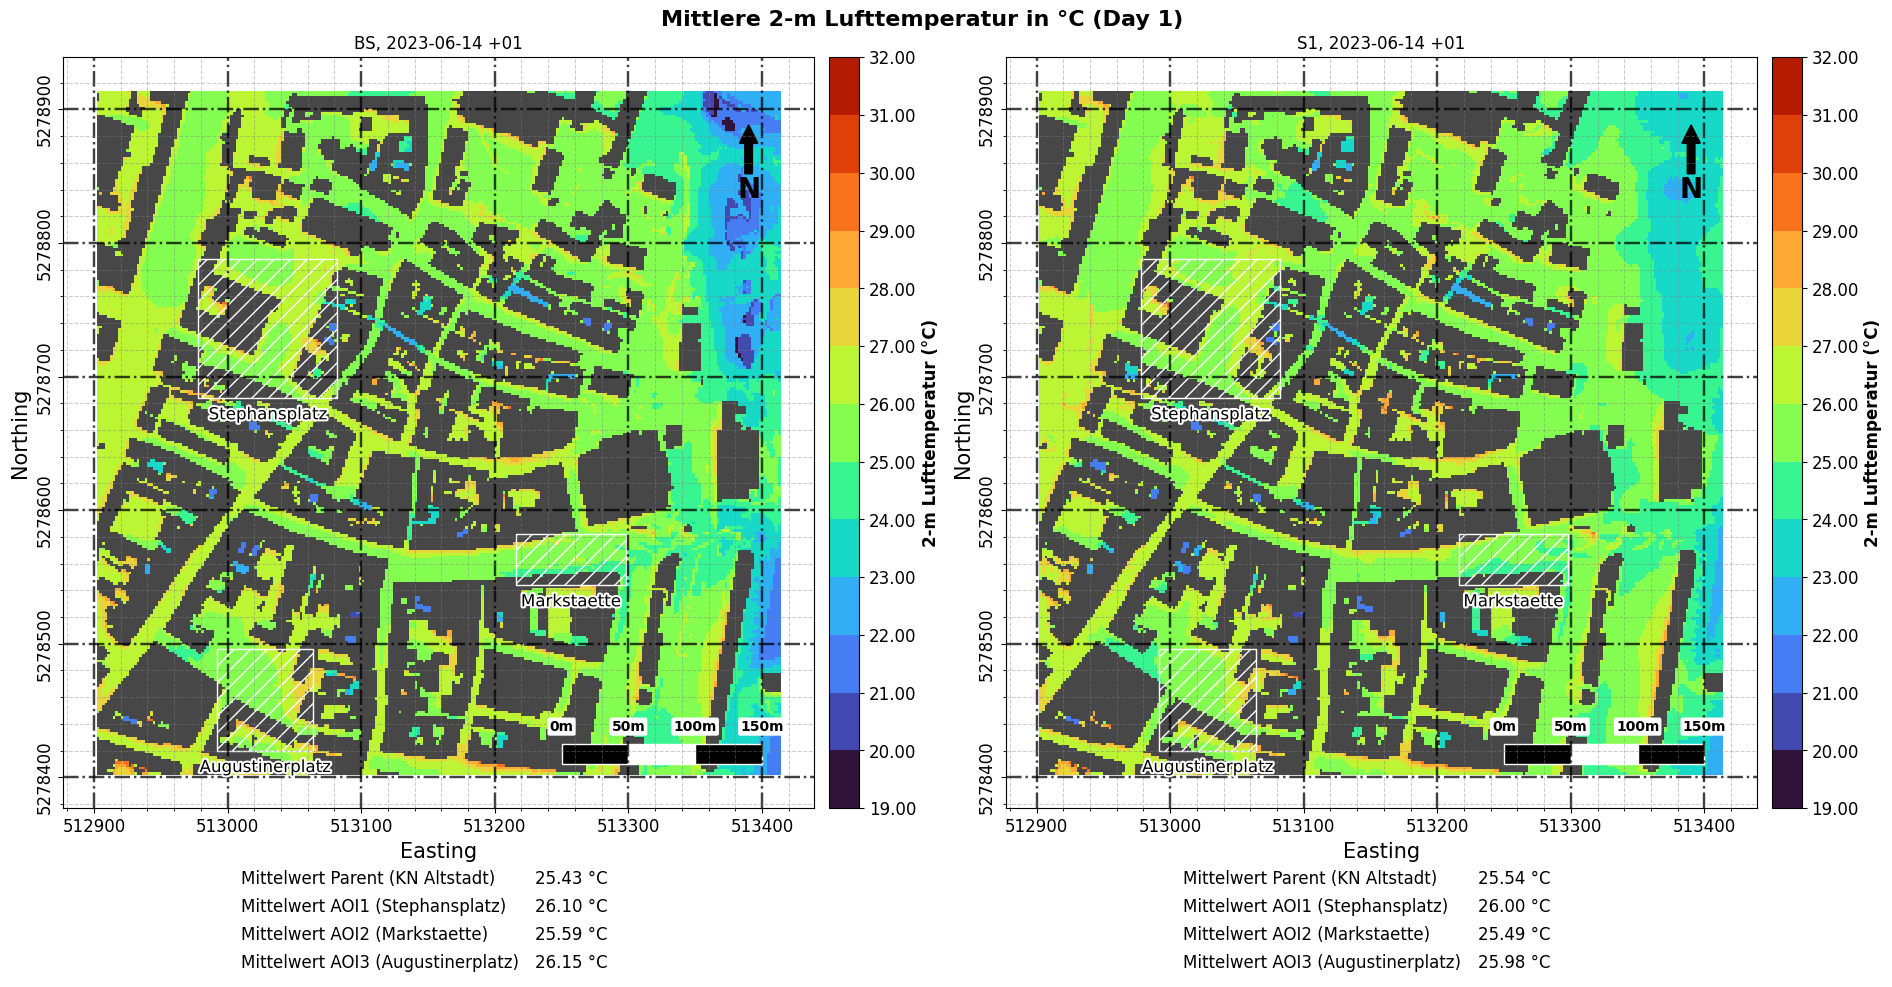

In [15]:
# Prepare lists of mean temperature arrays for plotting (Day 1: Baseline and Scenario 1).
list_to_plot_day1 = [mean_values_temp_day1_bs, mean_values_temp_day1_s1]
# Apply the building mask to these arrays to exclude non-atmospheric grid cells.
list_to_plot_day1_masked = [ma.array(list_to_plot_day1[0], mask=~buildings_2d_data.mask),
                            ma.array(list_to_plot_day1[1], mask=~buildings_2d_data.mask)]

# Titles for the subplots.
list_of_titles_day1 = ['BS, 2023-06-14 +01', 'S1, 2023-06-14 +01']

# Determine the overall min/max temperature values across both masked datasets for consistent color scaling.
value_max_day1 = max(np.nanmax(list_to_plot_day1_masked[0]), np.nanmax(list_to_plot_day1_masked[1]))
value_min_day1 = min(np.nanmin(list_to_plot_day1_masked[0]), np.nanmin(list_to_plot_day1_masked[1]))

# Define fixed min/max for color scale and interval for tick marks.
vmin = 19
vmax = 32
interval_temp = 1

# Calculate the number of intervals for the color bar ticks.
count_interval = int((vmax - vmin) / interval_temp)

# --- Plotting for Day 1 ---
# Create a figure and two subplots (1 row, 2 columns) for the heatmaps.
fig, axs = plt.subplots(1, 2, figsize=(19, 9), facecolor='w', edgecolor='k')
# Adjust subplot parameters for a tight layout, leaving space for the main title.
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
# Set global font size for the plot.
plt.rcParams.update({'font.size': 15})

# Set the main title of the plot.
fig.suptitle(f"Mittlere 2-m Lufttemperatur in {unit} (Day 1)", fontsize=16, weight='bold')

# Iterate through each scenario's data for plotting.
for i, variable_data in enumerate(list_to_plot_day1_masked):
    ax = axs[i] # Get the current subplot axes.

    # Define the colormap for the heatmap.
    cmap = plt.get_cmap('turbo') # 'turbo' is a good choice for continuous data.
    cmap.set_bad('#474747')     # Set color for masked (building) areas to dark grey.

    # Create a qualitative colormap from the sequential 'turbo' colormap.
    # This is done by taking discrete colors from the continuous colormap.
    num_colors = count_interval
    sequential_cmap = plt.get_cmap('turbo')
    colors = [sequential_cmap(j / num_colors) for j in range(num_colors)]
    qualitative_cmap = plt.cm.colors.ListedColormap(colors)
    qualitative_cmap.set_bad('#474747') # Ensure masked areas are consistent.

    # Plot the 2D temperature data as a pseudocolor mesh.
    pcm = ax.pcolormesh(x, y, variable_data, cmap=qualitative_cmap, vmin=vmin, vmax=vmax)
    
    # Extract raw values from the masked array for statistics (excluding masked data).
    values = variable_data[:,:]
    
    # Define a buffer distance for AOI plotting (in grid cells).
    buffer_distance = 10
    # Create a buffered GeoDataFrame for AOI visualization.
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    # Plot the buffered AOIs with a transparent fill, white edges, and a hatch pattern.
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    # Calculate mean temperature within each AOI.
    aoi_uhi_mean = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        # Convert geographic bounds to array indices.
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dy), int((max_x-origin_x)/dx), int((max_y-origin_y)/dy)

        # Extract values within the AOI, including the buffer.
        # The `get_extents` function could be used here for more robust boundary handling.
        value_mean_polygon = values[y1-buffer_distance:y2+buffer_distance, x1-buffer_distance:x2+buffer_distance]
        aoi_uhi_mean.append(value_mean_polygon)
        
        # Annotate each AOI with its name, positioned at the centroid with an offset.
        # `path_effects` adds a white stroke for better visibility against varying background colors.
        ax.annotate(row['Location'], 
                    xy=(polygon.centroid.x, min_y), 
                    xytext=(0,-25), 
                    textcoords="offset points", 
                    ha='center', 
                    fontsize=12,
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')])
        
    # Configure grid lines for the plot.
    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # Ensure the aspect ratio is equal for correct geographic representation.

    # Set minor ticks and grid lines for x and y axes.
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    # Customize tick parameters.
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12)
    center_yticks(ax) # Custom function to center y-tick labels.

    # Format y-axis major tick labels to show integers.
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y_val, pos: f'{y_val:.0f}'))
    # Set subplot title.
    ax.set_title(f"{list_of_titles_day1[i]}", fontsize=12)
    # Set plot limits (adjusting slightly beyond actual data extent for aesthetic).
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create a color bar for the heatmap.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform')
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top") # Position color bar ticks at the top.
    cb.ax.set_ylabel(f"2-m Lufttemperatur ({unit})", fontsize=12, weight="bold")
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1)) # Set major ticks for the color bar.

    # Create a table summarizing mean temperatures within the parent domain and AOIs.
    table_data = [
        ["Mittelwert Parent (KN Altstadt)", f"{np.nanmean(variable_data):.2f} {unit}"],
        [f"Mittelwert AOI1 ({location_name_list[1]})", f"{np.nanmean(aoi_uhi_mean[0]):.2f} {unit}"],
        [f"Mittelwert AOI2 ({location_name_list[2]})", f"{np.nanmean(aoi_uhi_mean[1]):.2f} {unit}"],
        [f"Mittelwert AOI3 ({location_name_list[3]})", f"{np.nanmean(aoi_uhi_mean[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.6, 0.15]) # Position the table below the plot.
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar(ax) # Add north arrow and scale bar to each subplot.
plt.show()

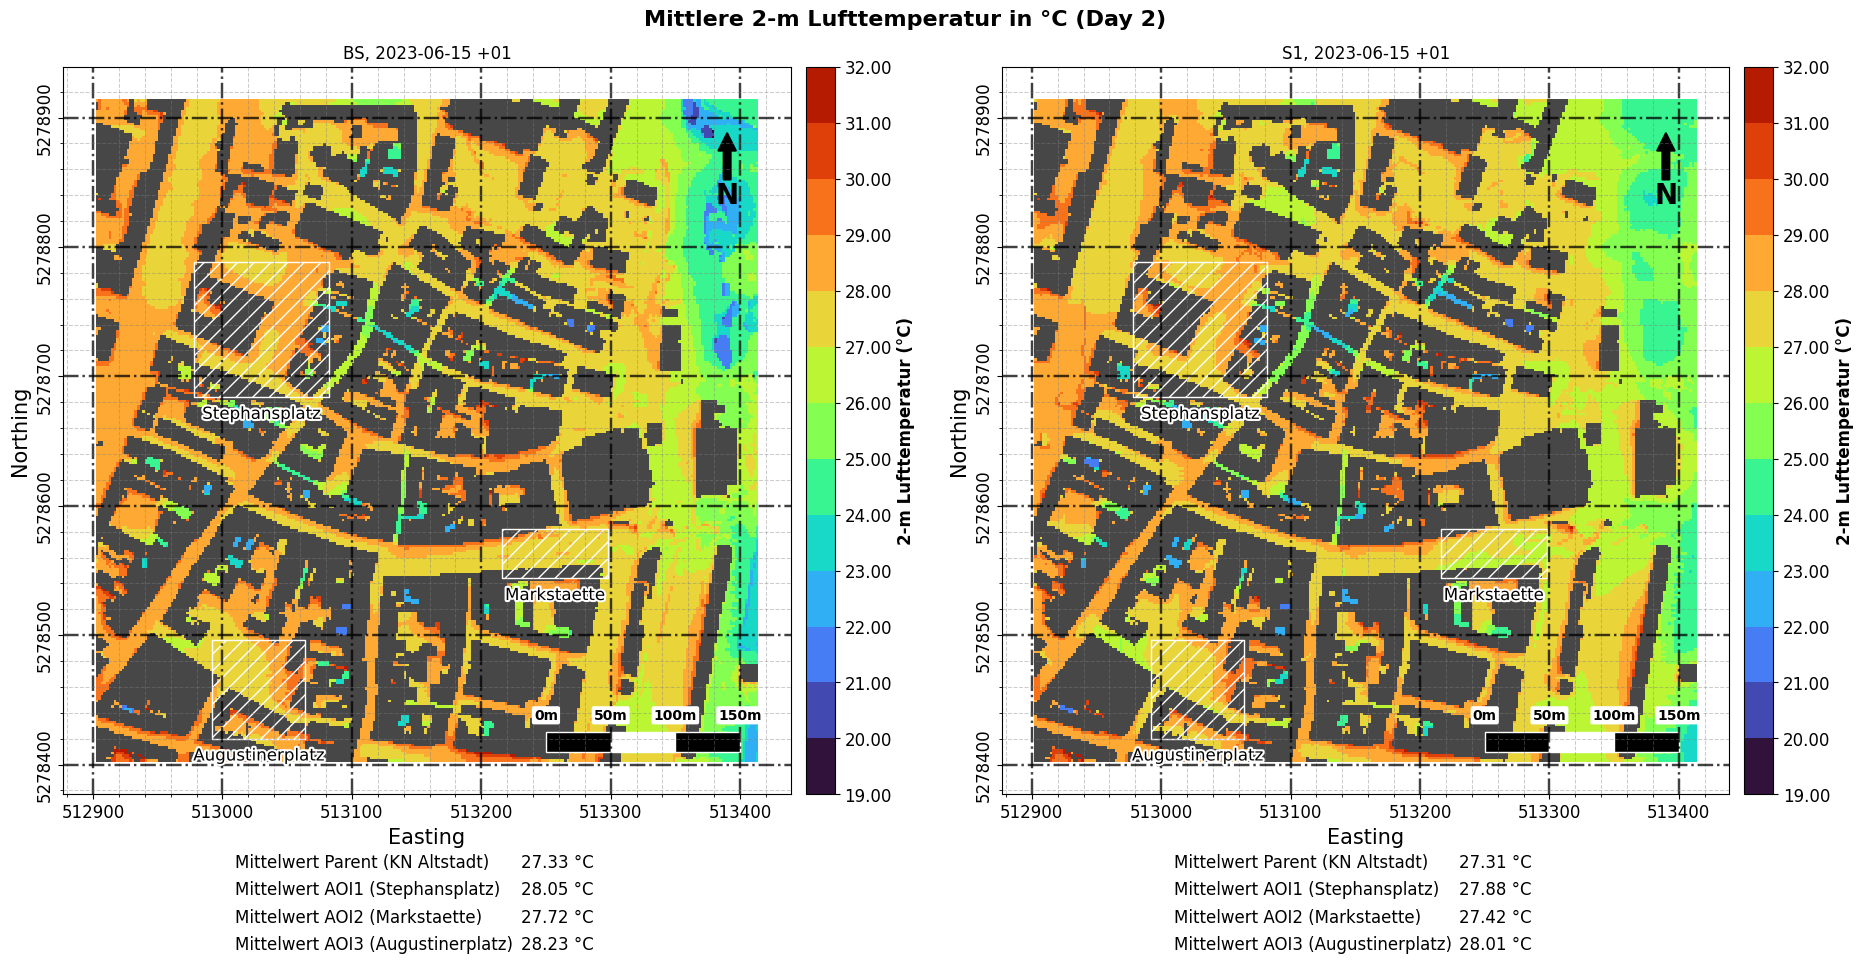

In [16]:
# Prepare lists of mean temperature arrays for plotting (Day 2: Baseline and Scenario 1).
list_to_plot_day2 = [mean_values_temp_day2_bs, mean_values_temp_day2_s1]
# Apply the building mask to these arrays to exclude non-atmospheric grid cells.
list_to_plot_day2_masked = [ma.array(list_to_plot_day2[0], mask=~buildings_2d_data.mask),
                            ma.array(list_to_plot_day2[1], mask=~buildings_2d_data.mask)]

# Titles for the subplots.
list_of_titles_day2 = ['BS, 2023-06-15 +01', 'S1, 2023-06-15 +01']

# Determine the overall min/max temperature values across both masked datasets for consistent color scaling.
value_max_day2 = max(np.nanmax(list_to_plot_day2_masked[0]), np.nanmax(list_to_plot_day2_masked[1]))
value_min_day2 = min(np.nanmin(list_to_plot_day2_masked[0]), np.nanmin(list_to_plot_day2_masked[1]))

# Define fixed min/max for color scale and interval for tick marks.
vmin = 19
vmax = 32
interval_temp = 1

# Calculate the number of intervals for the color bar ticks.
count_interval = int((vmax - vmin) / interval_temp)

# --- Plotting for Day 2 ---
# Create a figure and two subplots (1 row, 2 columns) for the heatmaps.
fig, axs = plt.subplots(1, 2, figsize=(19, 9), facecolor='w', edgecolor='k')
# Adjust subplot parameters for a tight layout, leaving space for the main title.
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
# Set global font size for the plot.
plt.rcParams.update({'font.size': 15})

# Set the main title of the plot.
fig.suptitle(f"Mittlere 2-m Lufttemperatur in {unit} (Day 2)", fontsize=16, weight='bold')

# Iterate through each scenario's data for plotting.
for i, variable_data in enumerate(list_to_plot_day2_masked):
    ax = axs[i] # Get the current subplot axes.

    # Define the colormap for the heatmap.
    cmap = plt.get_cmap('turbo') # 'turbo' is a good choice for continuous data.
    cmap.set_bad('#474747')     # Set color for masked (building) areas to dark grey.

    # Create a qualitative colormap from the sequential 'turbo' colormap.
    # This is done by taking discrete colors from the continuous colormap.
    num_colors = count_interval
    sequential_cmap = plt.get_cmap('turbo')
    colors = [sequential_cmap(j / num_colors) for j in range(num_colors)]
    qualitative_cmap = plt.cm.colors.ListedColormap(colors)
    qualitative_cmap.set_bad('#474747') # Ensure masked areas are consistent.

    # Plot the 2D temperature data as a pseudocolor mesh.
    pcm = ax.pcolormesh(x, y, variable_data, cmap=qualitative_cmap, vmin=vmin, vmax=vmax)
    
    # Extract raw values from the masked array for statistics (excluding masked data).
    values = variable_data[:,:]
    
    # Define a buffer distance for AOI plotting (in grid cells).
    buffer_distance = 10
    # Create a buffered GeoDataFrame for AOI visualization.
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    # Plot the buffered AOIs with a transparent fill, white edges, and a hatch pattern.
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    # Calculate mean temperature within each AOI.
    aoi_uhi_mean = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        # Convert geographic bounds to array indices.
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dy), int((max_x-origin_x)/dx), int((max_y-origin_y)/dy)

        # Extract values within the AOI, including the buffer.
        # The `get_extents` function could be used here for more robust boundary handling.
        value_mean_polygon = values[y1-buffer_distance:y2+buffer_distance, x1-buffer_distance:x2+buffer_distance]
        aoi_uhi_mean.append(value_mean_polygon)
        
        # Annotate each AOI with its name, positioned at the centroid with an offset.
        # `path_effects` adds a white stroke for better visibility against varying background colors.
        ax.annotate(row['Location'], 
                    xy=(polygon.centroid.x, min_y), 
                    xytext=(0,-25), 
                    textcoords="offset points", 
                    ha='center', 
                    fontsize=12,
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')])
        
    # Configure grid lines for the plot.
    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # Ensure the aspect ratio is equal for correct geographic representation.

    # Set minor ticks and grid lines for x and y axes.
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    # Customize tick parameters.
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12)
    center_yticks(ax) # Custom function to center y-tick labels.

    # Format y-axis major tick labels to show integers.
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y_val, pos: f'{y_val:.0f}'))
    # Set subplot title.
    ax.set_title(f"{list_of_titles_day2[i]}", fontsize=12)
    # Set plot limits (adjusting slightly beyond actual data extent for aesthetic).
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create a color bar for the heatmap.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform')
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top") # Position color bar ticks at the top.
    cb.ax.set_ylabel(f"2-m Lufttemperatur ({unit})", fontsize=12, weight="bold")
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1)) # Set major ticks for the color bar.

    # Create a table summarizing mean temperatures within the parent domain and AOIs.
    table_data = [
        ["Mittelwert Parent (KN Altstadt)", f"{np.nanmean(variable_data):.2f} {unit}"],
        [f"Mittelwert AOI1 ({location_name_list[1]})", f"{np.nanmean(aoi_uhi_mean[0]):.2f} {unit}"],
        [f"Mittelwert AOI2 ({location_name_list[2]})", f"{np.nanmean(aoi_uhi_mean[1]):.2f} {unit}"],
        [f"Mittelwert AOI3 ({location_name_list[3]})", f"{np.nanmean(aoi_uhi_mean[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.6, 0.15]) # Position the table below the plot.
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar(ax) # Add north arrow and scale bar to each subplot.
plt.show()

## 10. Visualize Mean Temperature Heatmaps (Night 1)
This section generates heatmaps to visualize the mean 2-meter air temperature for both Baseline and Scenario 1 during the nighttime period of Night 1. Similar to the daytime plots, it includes:

* Temperature Heatmaps: Displaying spatial temperature distribution using a turbo colormap.
* AOI Overlays: Outlining predefined Areas of Interest (AOIs) with buffers.
* Statistical Tables: Summarizing mean temperatures for the overall domain and specific AOIs.
Aesthetic Enhancements: Custom color bars, grid lines, and geographic elements (north arrow, scale bar) for improved interpretation.

The visualizations help to quickly identify hot and cold spots and the general temperature patterns in the simulated domain for each scenario during the night.

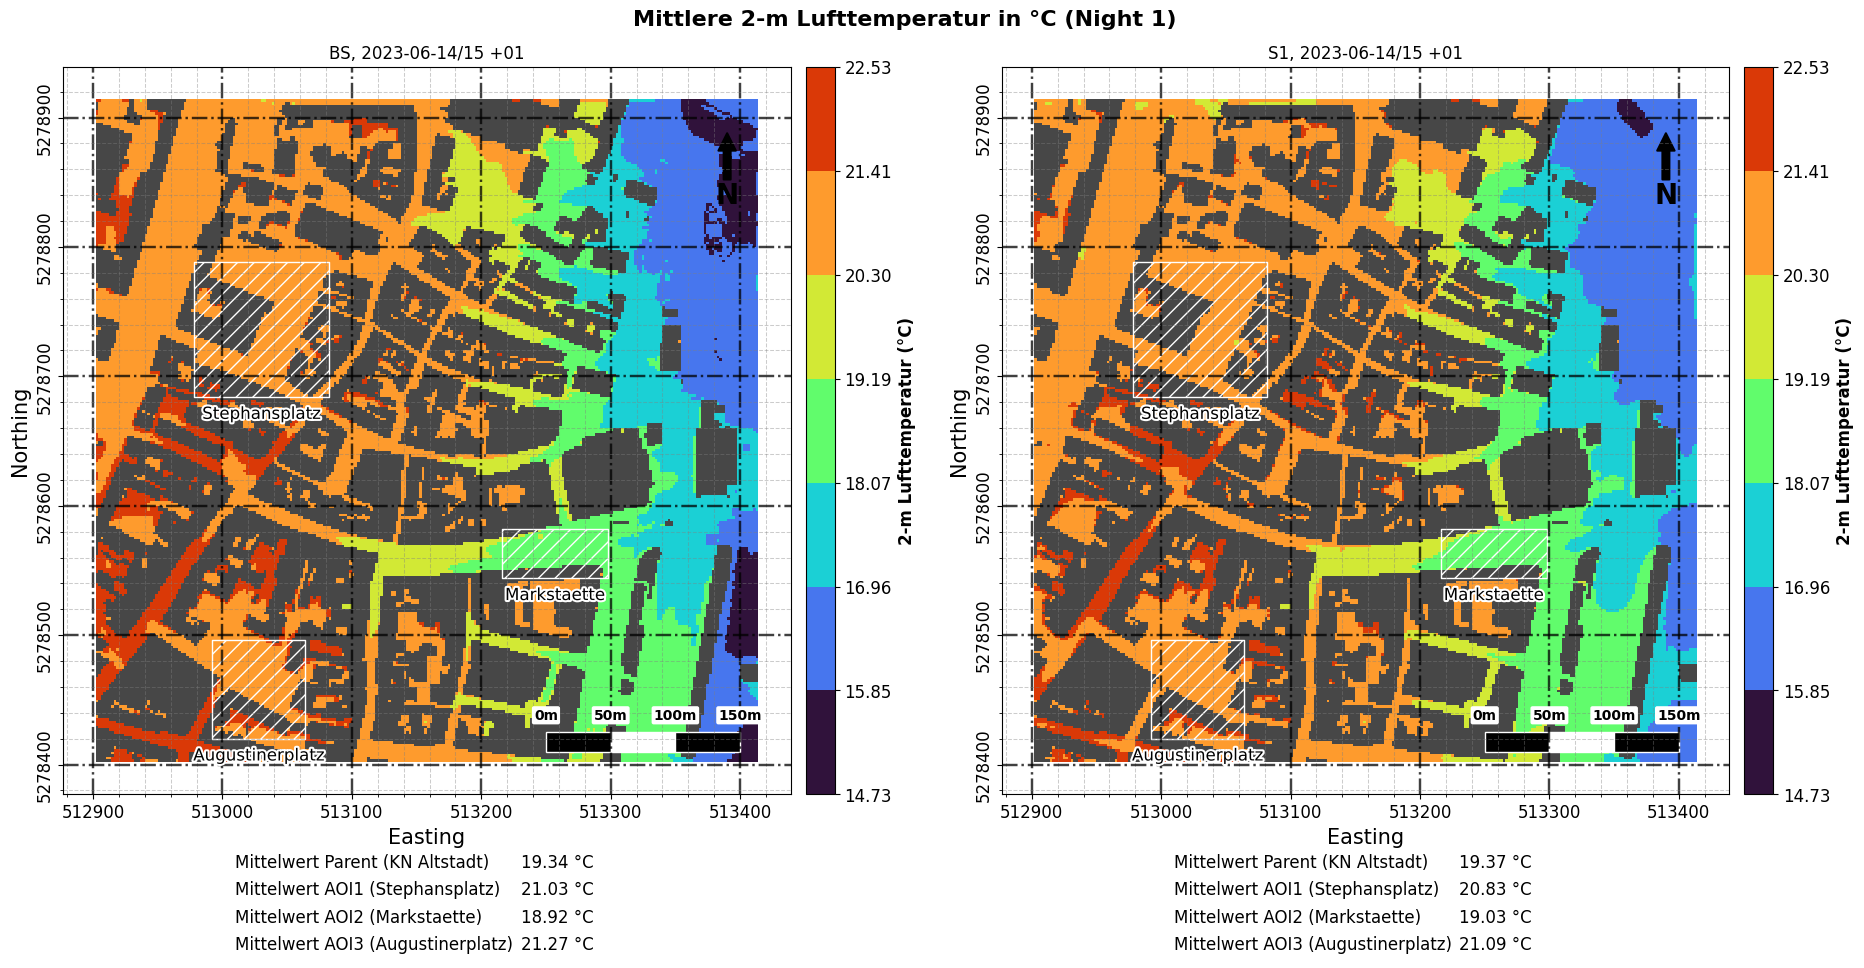

In [17]:
# Prepare lists of mean temperature arrays for plotting (Night 1: Baseline and Scenario 1).
list_to_plot_night1 = [mean_values_temp_night1_bs, mean_values_temp_night1_s1]
# Apply the building mask to these arrays to exclude non-atmospheric grid cells.
list_to_plot_night1_masked = [ma.array(list_to_plot_night1[0], mask=~buildings_2d_data.mask),
                            ma.array(list_to_plot_night1[1], mask=~buildings_2d_data.mask)]

# Titles for the subplots.
list_of_titles_night1 = ['BS, 2023-06-14/15 +01', 'S1, 2023-06-14/15 +01']

# Determine the overall min/max temperature values across both masked datasets for consistent color scaling.
value_max_night1 = max(np.nanmax(list_to_plot_night1_masked[0]), np.nanmax(list_to_plot_night1_masked[1]))
value_min_night1 = min(np.nanmin(list_to_plot_night1_masked[0]), np.nanmin(list_to_plot_night1_masked[1]))

# Define fixed min/max for color scale and interval for tick marks.
vmin = value_min_night1
vmax = value_max_night1
interval_temp = 1

# Calculate the number of intervals for the color bar ticks.
count_interval = int((vmax - vmin) / interval_temp)

# --- Plotting for Night 1 ---
# Create a figure and two subplots (1 row, 2 columns) for the heatmaps.
fig, axs = plt.subplots(1, 2, figsize=(19, 9), facecolor='w', edgecolor='k')
# Adjust subplot parameters for a tight layout, leaving space for the main title.
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
# Set global font size for the plot.
plt.rcParams.update({'font.size': 15})

# Set the main title of the plot.
fig.suptitle(f"Mittlere 2-m Lufttemperatur in {unit} (Night 1)", fontsize=16, weight='bold')

# Iterate through each scenario's data for plotting.
for i, variable_data in enumerate(list_to_plot_night1_masked):
    ax = axs[i] # Get the current subplot axes.

    # Define the colormap for the heatmap.
    cmap = plt.get_cmap('turbo') # 'turbo' is a good choice for continuous data.
    cmap.set_bad('#474747')     # Set color for masked (building) areas to dark grey.

    # Create a qualitative colormap from the sequential 'turbo' colormap.
    # This is done by taking discrete colors from the continuous colormap.
    num_colors = count_interval
    sequential_cmap = plt.get_cmap('turbo')
    colors = [sequential_cmap(j / num_colors) for j in range(num_colors)]
    qualitative_cmap = plt.cm.colors.ListedColormap(colors)
    qualitative_cmap.set_bad('#474747') # Ensure masked areas are consistent.

    # Plot the 2D temperature data as a pseudocolor mesh.
    pcm = ax.pcolormesh(x, y, variable_data, cmap=qualitative_cmap, vmin=vmin, vmax=vmax)
    
    # Extract raw values from the masked array for statistics (excluding masked data).
    values = variable_data[:,:]
    
    # Define a buffer distance for AOI plotting (in grid cells).
    buffer_distance = 10
    # Create a buffered GeoDataFrame for AOI visualization.
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    # Plot the buffered AOIs with a transparent fill, white edges, and a hatch pattern.
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    # Calculate mean temperature within each AOI.
    aoi_uhi_mean = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        # Convert geographic bounds to array indices.
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dy), int((max_x-origin_x)/dx), int((max_y-origin_y)/dy)

        # Extract values within the AOI, including the buffer.
        # The `get_extents` function could be used here for more robust boundary handling.
        value_mean_polygon = values[y1-buffer_distance:y2+buffer_distance, x1-buffer_distance:x2+buffer_distance]
        aoi_uhi_mean.append(value_mean_polygon)
        
        # Annotate each AOI with its name, positioned at the centroid with an offset.
        # `path_effects` adds a white stroke for better visibility against varying background colors.
        ax.annotate(row['Location'], 
                    xy=(polygon.centroid.x, min_y), 
                    xytext=(0,-25), 
                    textcoords="offset points", 
                    ha='center', 
                    fontsize=12,
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')])
        
    # Configure grid lines for the plot.
    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)  # Ensure the aspect ratio is equal for correct geographic representation.

    # Set minor ticks and grid lines for x and y axes.
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

    # Customize tick parameters.
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12)
    center_yticks(ax) # Custom function to center y-tick labels.

    # Format y-axis major tick labels to show integers.
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y_val, pos: f'{y_val:.0f}'))
    # Set subplot title.
    ax.set_title(f"{list_of_titles_night1[i]}", fontsize=12)
    # Set plot limits (adjusting slightly beyond actual data extent for aesthetic).
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create a color bar for the heatmap.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform')
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top") # Position color bar ticks at the top.
    cb.ax.set_ylabel(f"2-m Lufttemperatur ({unit})", fontsize=12, weight="bold")
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1)) # Set major ticks for the color bar.

    # Create a table summarizing mean temperatures within the parent domain and AOIs.
    table_data = [
        ["Mittelwert Parent (KN Altstadt)", f"{np.nanmean(variable_data):.2f} {unit}"],
        [f"Mittelwert AOI1 ({location_name_list[1]})", f"{np.nanmean(aoi_uhi_mean[0]):.2f} {unit}"],
        [f"Mittelwert AOI2 ({location_name_list[2]})", f"{np.nanmean(aoi_uhi_mean[1]):.2f} {unit}"],
        [f"Mittelwert AOI3 ({location_name_list[3]})", f"{np.nanmean(aoi_uhi_mean[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.6, 0.15]) # Position the table below the plot.
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar(ax) # Add north arrow and scale bar to each subplot.
plt.show()

In [18]:
# ## Uncomment and run to generate plots for all time sequences

# # time_equivalent, time_equivalent_24hr = list_to_24hour(time_sequence)

# for hour in range(0,48,1):

#     hour_index = time_sequence[hour]
#     hour_index

#     band_values1 = variable_data_1[hour_index, 0, :, :]
#     band_values2 = variable_data_2[hour_index, 0, :, :]

#     hour_list_to_plot = [band_values1, band_values2]

#     hour_list_to_plot_masked = [ma.array(hour_list_to_plot[0], mask=~buildings_2d_data.mask),
#                                 ma.array(hour_list_to_plot[1], mask=~buildings_2d_data.mask)]

#     value_max = max(np.nanmax(hour_list_to_plot_masked[0]), np.nanmax(hour_list_to_plot_masked[1]))
#     value_min = min(np.nanmin(hour_list_to_plot_masked[0]), np.nanmin(hour_list_to_plot_masked[1]))

#     vmin = ma.floor(value_min)
#     vmax = ma.ceil(value_max)

#     # Plotting the masked t_test_results using a heatmap
#     fig, axs = plt.subplots(1,2, figsize=(19, 9), facecolor='w', edgecolor='k')
#     fig.tight_layout(rect=[0, 0.05, 1, 0.95])
#     fig.suptitle(f'2m Lufttemperatur {time_equivalent_24hr[hour]} ', fontsize=16)

#     plt.rcParams.update({'font.size': 15})

#     for i, variable_data in enumerate(hour_list_to_plot_masked):
#         ax = axs[i]

#         # Define plot color and mask color
#         cmap = plt.get_cmap('turbo')  # Other cmap: jet, turbo, rainbow,
#         cmap.set_bad('#474747')  # 474747

#         # Define qualitative from sequential cmap
#         count_interval = 16
#         num_colors = count_interval
#         sequential_cmap = plt.get_cmap('turbo')
#         colors = [sequential_cmap(i / num_colors) for i in range(num_colors)]
#         qualitative_cmap = plt.cm.colors.ListedColormap(colors)
#         qualitative_cmap.set_bad('#474747')

#         pcm = ax.pcolormesh(x,y, variable_data, cmap=qualitative_cmap, vmin=14, vmax=30)
        
#         # Compute statistics
#         values = variable_data[:,:]
        
#         buffer_distance = half_window_2 = 10
#         # Plot shapefile and calculate mean within each polygon
#         buffered_gdf = gdf_uhi.copy()
#         buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
#         buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

#         aoi_uhi_mean = []
#         for index, row in gdf_uhi.iterrows():
#             polygon = row.geometry
#             min_x, min_y, max_x, max_y = polygon.bounds
#             x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

#             half_window = half_window_2
#             value_mean_polygon = values[y1-half_window:y2+half_window, x1-half_window:x2+half_window]
#             aoi_uhi_mean.append(value_mean_polygon)
            
#             ax.annotate(row['Location'], 
#                 xy=(polygon.centroid.x, min_y), 
#                 xytext=(0,-25), 
#                 textcoords="offset points", 
#                 ha='center', 
#                 fontsize=12,
#                 path_effects=[pe.withStroke(linewidth=3, foreground='white')])
        
#         ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
#         ax.set_xlabel('Easting', fontsize=15)
#         ax.set_ylabel('Northing', fontsize=15)
#         ax.set_aspect(1)  # 1 or 'equal'

#         ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
#         ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
#         ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
#         ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)

#         ax.tick_params(axis='x', labelsize=12)
#         ax.tick_params(axis='y', labelrotation=90, labelsize=12, )
#         center_yticks(ax)

#         ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.0f}'))
        
#         if hour > 24:
#             ax.set_title(f"{list_of_titles[i].replace('14','15')}", fontsize=12)
#         else:
#             ax.set_title(f"{list_of_titles[i]}", fontsize=12)
        
#         ax.set_xlim(x[0]-25, x[-1]+25)
#         ax.set_ylim(y[0]-25, y[-1]+25)

#         # Create color bar
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="4%", pad=0.15)
#         cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform', )
#         cb.ax.tick_params(labelsize=12, rotation=0)
#         cb.ax.xaxis.set_ticks_position("top")
#         cb.ax.set_ylabel(f"2-m Lufttemperatur ({unit})", fontsize=12, weight="bold")
#         # locator = MultipleLocator(5)
#         cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval+1))
#         # cb.ax.tick_params(rotation=90)
#         # center_yticks(cb.ax)
            

#     plt.savefig(f"./air_temp{hour}")
#     plt.show()

## 11. Visualize Mean Temperature Difference Heatmaps (Day 1 and Day 2)

This section calculates and visualizes the spatial difference in mean 2-meter air temperature between Scenario 1 and Baseline for daytime periods of Day 1 and Day 2. The plots highlight areas where temperature changes are most prominent.

* Difference Heatmaps: Displaying the spatial temperature difference using a diverging colormap centered at zero, showing both cooling and warming effects.
* AOI Overlays: Outlining predefined Areas of Interest (AOIs) with buffers.
* Statistical Tables: Summarizing mean temperature differences for the overall domain and specific AOIs.
* Aesthetic Enhancements: Custom color bars, grid lines, and geographic elements (north arrow, scale bar) for improved interpretation.

The visualizations help to quickly identify areas with significant temperature impacts due to the changes introduced in Scenario 1.

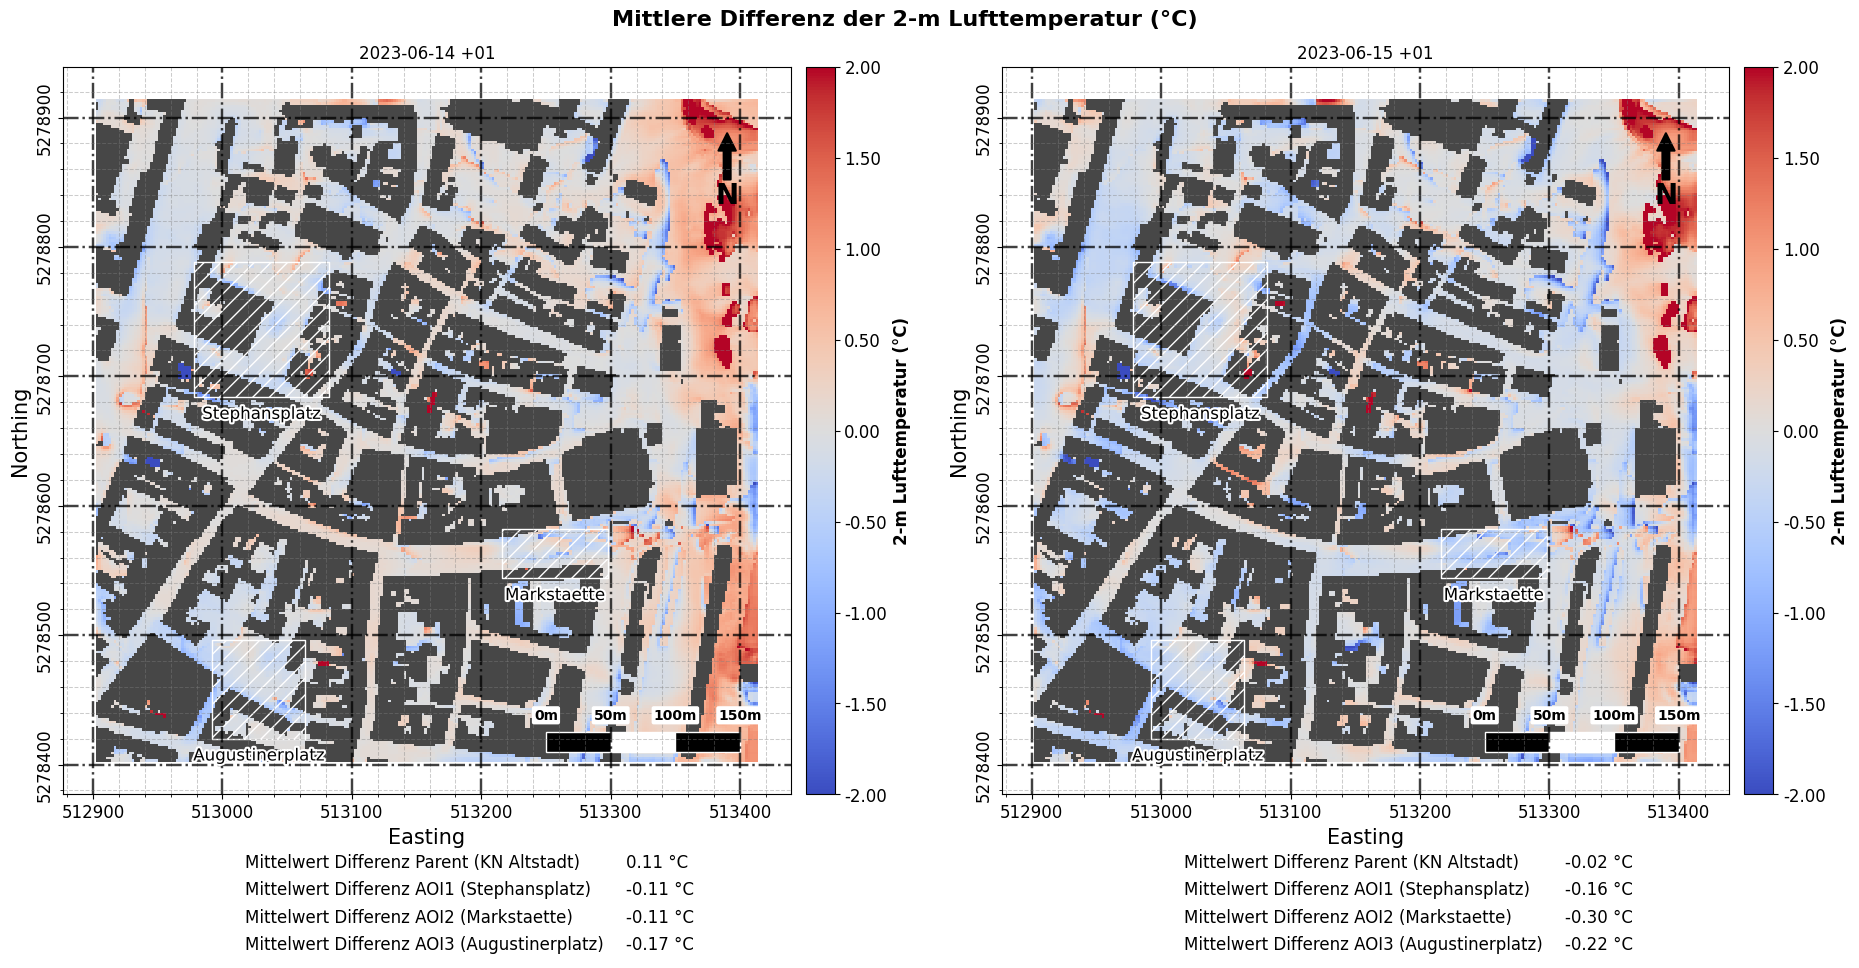

In [19]:
# Calculate the difference in mean temperatures (Scenario 1 - Baseline) for each period.
difference_values_day1 = mean_values_temp_day1_s1 - mean_values_temp_day1_bs
difference_values_day2 = mean_values_temp_day2_s1 - mean_values_temp_day2_bs
difference_values_night1 = mean_values_temp_night1_s1 - mean_values_temp_night1_bs

# Prepare lists of difference arrays for plotting (Day 1 and Day 2).
list_to_plot_diff = [difference_values_day1, difference_values_day2]
# Apply the building mask to these arrays.
list_to_plot_diff_masked = [ma.array(list_to_plot_diff[0], mask=~buildings_2d_data.mask),
                            ma.array(list_to_plot_diff[1], mask=~buildings_2d_data.mask)]

# Titles for the difference subplots.
list_of_titles_diff = ['2023-06-14 +01', '2023-06-15 +01']

# Define fixed min/max for the color scale of the difference map (centered at 0).
vmin_diff = -2.0
vmax_diff = 2.0
interval_diff = 0.5

# Calculate the number of intervals for the color bar ticks.
count_interval_diff = int((vmax_diff - vmin_diff) / interval_diff)

# --- Plotting Mean Difference for Day 1 and Day 2 ---
# Create a figure and two subplots.
fig, axs = plt.subplots(1, 2, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

# Set the main title for the difference plot.
fig.suptitle(f"Mittlere Differenz der 2-m Lufttemperatur ({unit})", fontsize=16, weight='bold')

for i, variable_data in enumerate(list_to_plot_diff_masked):
    ax = axs[i]

    # Define a diverging colormap ('coolwarm') centered at zero for differences.
    cmap = plt.get_cmap('coolwarm')
    cmap.set_bad('#474747')

    # Plot the difference data.
    pcm = ax.pcolormesh(x, y, variable_data, cmap=cmap, vmin=vmin_diff, vmax=vmax_diff)
    
    # Extract raw values for statistics.
    values = variable_data[:,:]
    
    # Define buffer distance and plot buffered AOIs.
    buffer_distance = 10
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    buffered_gdf.plot(ax=ax, color='none', edgecolor='w', linewidth=1.0, alpha=1, hatch='//')

    # Calculate mean difference within each AOI.
    aoi_uhi_mean_diff = []
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dy), int((max_x-origin_x)/dx), int((max_y-origin_y)/dy)

        value_mean_polygon = values[y1-buffer_distance:y2+buffer_distance, x1-buffer_distance:x2+buffer_distance]
        aoi_uhi_mean_diff.append(value_mean_polygon)
        
        # Annotate AOIs.
        ax.annotate(row['Location'], 
                    xy=(polygon.centroid.x, min_y), 
                    xytext=(0,-25), 
                    textcoords="offset points", 
                    ha='center', 
                    fontsize=12,
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')])

    # Configure grid, labels, and ticks.
    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12)
    center_yticks(ax)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y_val, pos: f'{y_val:.0f}'))
    ax.set_title(f"{list_of_titles_diff[i]}", fontsize=12)
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)

    # Create color bar for difference map.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform')
    cb.ax.tick_params(labelsize=12, rotation=0)
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel(f"2-m Lufttemperatur ({unit})", fontsize=12, weight="bold")
    cb.ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=count_interval_diff+1))

    # Create a table summarizing mean differences.
    table_data_diff = [
        ["Mittelwert Differenz Parent (KN Altstadt)", f"{np.nanmean(variable_data):.2f} {unit}"],
        [f"Mittelwert Differenz AOI1 ({location_name_list[1]})", f"{np.nanmean(aoi_uhi_mean_diff[0]):.2f} {unit}"],
        [f"Mittelwert Differenz AOI2 ({location_name_list[2]})", f"{np.nanmean(aoi_uhi_mean_diff[1]):.2f} {unit}"],
        [f"Mittelwert Differenz AOI3 ({location_name_list[3]})", f"{np.nanmean(aoi_uhi_mean_diff[2]):.2f} {unit}"]
    ]
    table = ax.table(cellText=table_data_diff,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.45, 0.2],
                     edges='open',
                     bbox=[0.195, -0.225, 0.8, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar(ax)
plt.show()

## 12. Perform T-test at Individual Pixels
This section performs independent t-tests for each individual grid cell (pixel) between the Baseline and Scenario 1 simulations for the defined day and night periods. The goal is to identify areas where the temperature difference is statistically significant.

* Pixel-wise T-test: Iterates through every pixel and applies scipy.stats.ttest_ind to the time series data of that pixel from both scenarios.
* Significance Masking: Creates a 2D array where pixels are marked based on whether the null hypothesis (no significant difference) is rejected (p<α) or failed to be rejected (p≥α).

These t-test results will be used in the next section for visualization.

In [20]:
import numpy as np
from scipy import stats
from pathlib import Path

# Define the significance level (alpha) for the t-test.
alpha_test = 0.05

# Get the spatial dimensions (number of y and x cells) from `band_values1`.
band_shape = np.shape(band_values1)[1:]

# Define cache file path
cache_file = Path("t_test_results.npz")

# Check if the cached file exists
if cache_file.exists():
    # Load precomputed t-test results
    with np.load(cache_file) as data:
        t_test_results_day1 = data["day1"]
        t_test_results_day2 = data["day2"]
        t_test_results_night1 = data["night1"]

else:
    # Initialize 2D arrays to store t-test results for Day 1 and Day 2. 
    # A value of 1 typically indicates 'Reject null' (significant difference),
    # and 2 indicates 'Failed to reject null' (no significant difference).
    t_test_results_day1 = np.zeros((band_shape[0], band_shape[1]))
    t_test_results_day2 = np.zeros((band_shape[0], band_shape[1]))
    t_test_results_night1 = np.zeros((band_shape[0], band_shape[1]))

    # --- Perform t-test for Day 1 --- 
    # Iterate over each pixel in the spatial domain.
    for i in range(band_shape[0]):  # Loop through y-dimension
        for j in range(band_shape[1]):  # Loop through x-dimension
            values_temp_1 = [] # Store time series data for Baseline.
            values_temp_2 = [] # Store time series data for Scenario 1.

            # Extract time series data for the current pixel (i,j) within the Day 1 time window.
            for time_index_temp in list_day_1:
                temp_1 = band_values1[time_index_temp, i, j]
                temp_2 = band_values2[time_index_temp, i, j]

                values_temp_1.append(temp_1)
                values_temp_2.append(temp_2)

            # Perform independent t-test (assuming unequal variances is generally safer if not known).
            t_statistic, p_value_ttest = stats.ttest_ind(values_temp_1, values_temp_2, equal_var=False)

            # Store the result based on the p-value compared to alpha.
            if p_value_ttest < alpha_test:
                t_test_results_day1[i, j] = 1  # Reject null hypothesis (significant difference).
            else:
                t_test_results_day1[i, j] = 2  # Failed to reject null hypothesis (no significant difference).

    # --- Perform t-test for Day 2 --- 
    for i in range(band_shape[0]):  # Loop through y-dimension
        for j in range(band_shape[1]):  # Loop through x-dimension
            values_temp_1 = []
            values_temp_2 = []

            # Extract time series data for the current pixel (i,j) within the Day 2 time window.
            for time_index_temp in list_day_2:
                temp_1 = band_values1[time_index_temp, i, j]
                temp_2 = band_values2[time_index_temp, i, j]

                values_temp_1.append(temp_1)
                values_temp_2.append(temp_2)

            # Perform independent t-test.
            t_statistic, p_value_ttest = stats.ttest_ind(values_temp_1, values_temp_2, equal_var=False)

            # Store the result.
            if p_value_ttest < alpha_test:
                t_test_results_day2[i, j] = 1
            else:
                t_test_results_day2[i, j] = 2

    # --- Perform t-test for Night 1 --- 
    for i in range(band_shape[0]):  # Loop through y-dimension
        for j in range(band_shape[1]):  # Loop through x-dimension
            values_temp_1 = []
            values_temp_2 = []

            # Extract time series data for the current pixel (i,j) within the Night 1 time window.
            for time_index_temp in list_night_1:
                temp_1 = band_values1[time_index_temp, i, j]
                temp_2 = band_values2[time_index_temp, i, j]

                values_temp_1.append(temp_1)
                values_temp_2.append(temp_2)

            # Perform independent t-test.
            t_statistic, p_value_ttest = stats.ttest_ind(values_temp_1, values_temp_2, equal_var=False)

            # Store the result.
            if p_value_ttest < alpha_test:
                t_test_results_night1[i, j] = 1
            else:
                t_test_results_night1[i, j] = 2

    # Save results to cache for future fast loading
    np.savez_compressed(
        cache_file,
        day1=t_test_results_day1,
        day2=t_test_results_day2,
        night1=t_test_results_night1
    )

## 13. Visualize T-test Results Heatmaps (Day 1 and Day 2)
This section generates heatmaps to visualize the results of the pixel-wise independent t-tests for Day 1 and Day 2. The heatmaps clearly distinguish between areas where temperature differences are statistically significant versus areas where they are not.

* T-test Heatmaps: Displaying pixels colored based on the t-test outcome (Reject Null or Fail to Reject Null).
* AOI Overlays: Outlining predefined Areas of Interest (AOIs) with buffers.
* Statistical Tables: Summarizing the count and percentage of pixels within each AOI that either rejected or failed to reject the null hypothesis.
* Aesthetic Enhancements: Custom color bars, grid lines, and geographic elements (north arrow, scale bar) for improved interpretation.

These visualizations provide crucial insights into the spatial extent of the impact of Scenario 1 on air temperature.

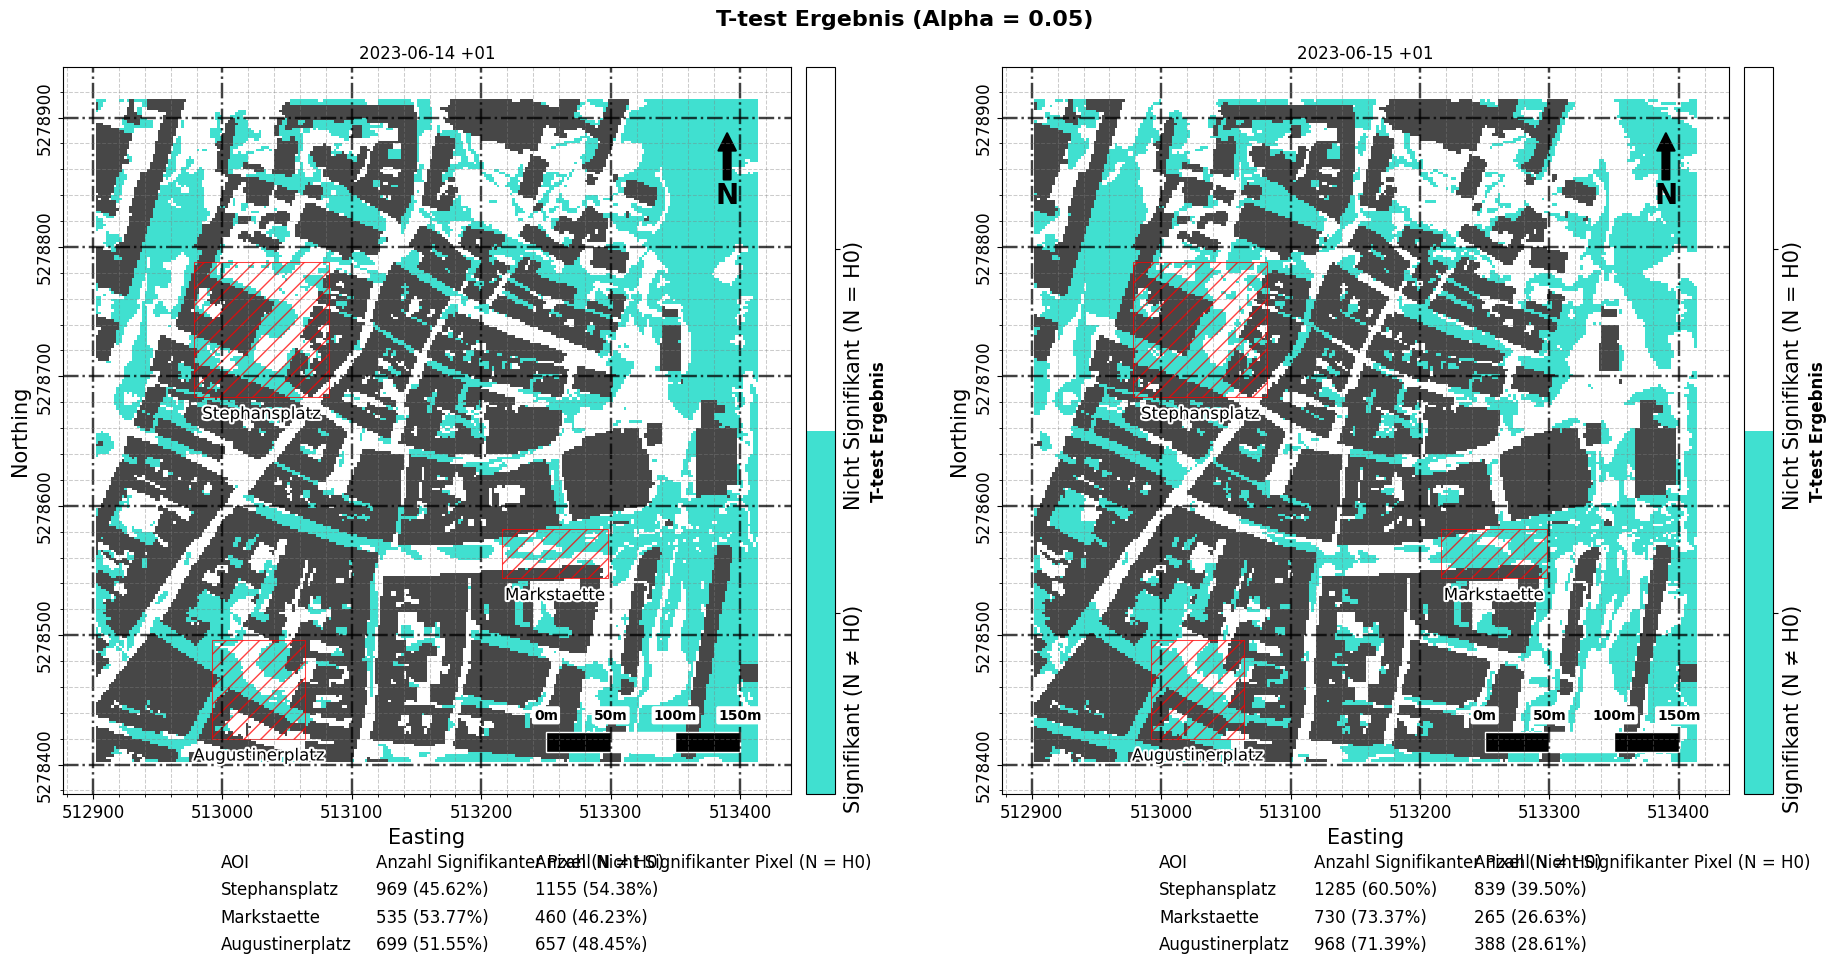

In [21]:
# Prepare lists of t-test result arrays for plotting (Day 1 and Day 2).
t_test_results_list_masked_day = [ma.array(t_test_results_day1, mask=~buildings_2d_data.mask),
                                   ma.array(t_test_results_day2, mask=~buildings_2d_data.mask)]

# Titles for the t-test result subplots.
list_of_titles_ttest_day = ['2023-06-14 +01', '2023-06-15 +01']

# --- Plotting T-test Results for Day 1 and Day 2 ---
# Create a figure and two subplots.
fig, axs = plt.subplots(1, 2, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

# Set the main title for the t-test result plot.
fig.suptitle(f"T-test Ergebnis (Alpha = {alpha_test})", fontsize=16, weight='bold')

for i, variable_data in enumerate(t_test_results_list_masked_day):
    ax = axs[i]
    
    # Define a custom colormap for t-test results:
    # - '#40E0D0' (turquoise) for 'Reject null' (significant difference, value 1).
    # - '#ffffff' (white) for 'Failed to reject null' (no significant difference, value 2).
    cmap = lsc.from_list("CustomCmap", ['#40E0D0', '#ffffff'], N=2)
    cmap.set_bad('#474747') # Grey for masked (building) areas.
    
    # Plot the t-test result data.
    pcm = ax.pcolormesh(x, y, variable_data, cmap=cmap, vmin=1, vmax=2) # vmin/vmax ensure 1 and 2 map correctly to colors.
    
    # Extract raw values for statistics.
    values = variable_data[:,:]
    
    # Define buffer distance and plot buffered AOIs.
    buffer_distance = 10
    buffered_gdf = gdf_uhi.copy()
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
    buffered_gdf.plot(ax=ax, color='none', edgecolor='r', linewidth=0.75, alpha=0.75, hatch='//') # Red edges for AOIs.
    
    # Initialize lists to store counts of 'Reject null' (count_1) and 'Failed to reject null' (count_2) pixels.
    count_1 = []
    count_2 = []
    count_sum = [] # Total count of valid pixels within each AOI.

    # Iterate through each AOI to compute pixel counts.
    for index, row in gdf_uhi.iterrows():
        polygon = row.geometry
        min_x, min_y, max_x, max_y = polygon.bounds
        x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dy), int((max_x-origin_x)/dx), int((max_y-origin_y)/dy)

        # Extract values within the AOI, including the buffer.
        values_polygon = values[y1-buffer_distance:y2+buffer_distance, x1-buffer_distance:x2+buffer_distance]
        # Count pixels with value 1 (Reject null) and 2 (Failed to reject null).
        count_ones = np.sum(values_polygon == 1)
        count_twos = np.sum(values_polygon == 2)

        count_1.append(count_ones)
        count_2.append(count_twos)
        count_sum.append(count_ones + count_twos)
        
        # Annotate AOIs.
        ax.annotate(row['Location'], 
                    xy=(polygon.centroid.x, min_y), 
                    xytext=(0,-25), 
                    textcoords="offset points", 
                    ha='center', 
                    fontsize=12,
                    path_effects=[pe.withStroke(linewidth=3, foreground='white')])
    
    # Configure grid, labels, and ticks.
    ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
    ax.set_xlabel('Easting', fontsize=15)
    ax.set_ylabel('Northing', fontsize=15)
    ax.set_aspect(1)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelrotation=90, labelsize=12)
    center_yticks(ax)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y_val, pos: f'{y_val:.0f}'))
    ax.set_title(f'{list_of_titles_ttest_day[i]}', fontsize=12)
    ax.set_xlim(x[0]-25, x[-1]+25)
    ax.set_ylim(y[0]-25, y[-1]+25)
    
    # Create color bar for t-test results.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform')
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.set_ylabel("T-test Ergebnis", fontsize=12, weight="bold")

    # Set custom ticks and labels for the color bar.
    custom_ticks = [1.25, 1.75]
    custom_labels = ['Signifikant (N ≠ H0)', 'Nicht Signifikant (N = H0)'] # N ≠ H0: Null hypothesis rejected
                                                                         # N = H0: Null hypothesis failed to be rejected
    cb.set_ticks(custom_ticks)
    cb.set_ticklabels(custom_labels)
    cb.ax.tick_params(rotation=90)
    
    # Create a table summarizing t-test results by pixel count and percentage within AOIs.
    table_data = [
        ["AOI", "Anzahl Signifikanter Pixel (N ≠ H0)", "Anzahl Nicht Signifikanter Pixel (N = H0)"], 
        [f"{location_name_list[1]}", f"{count_1[0]} ({(count_1[0]/count_sum[0])*100:.2f}%)", f"{count_2[0]} ({(count_2[0]/count_sum[0])*100:.2f}%)"],
        [f"{location_name_list[2]}", f"{count_1[1]} ({(count_1[1]/count_sum[1])*100:.2f}%)", f"{count_2[1]} ({(count_2[1]/count_sum[1])*100:.2f}%)"],
        [f"{location_name_list[3]}", f"{count_1[2]} ({(count_1[2]/count_sum[2])*100:.2f}%)", f"{count_2[2]} ({(count_2[2]/count_sum[2])*100:.2f}%)"],
    ]
    table = ax.table(cellText=table_data,
                     loc='bottom',
                     cellLoc='left',
                     colWidths=[0.35, 0.35, 0.45],
                     edges='open',
                     bbox=[0.195, -0.225, 0.7, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    plot_north_arrow_and_scale_bar(ax)
plt.show()

## 14. Visualize T-test Results Heatmaps (Night 1)
This section generates heatmaps to visualize the results of the pixel-wise independent t-tests for Night 1. The heatmaps clearly distinguish between areas where temperature differences are statistically significant versus areas where they are not.

* T-test Heatmaps: Displaying pixels colored based on the t-test outcome (Reject Null or Fail to Reject Null).
* AOI Overlays: Outlining predefined Areas of Interest (AOIs) with buffers.
* Statistical Tables: Summarizing the count and percentage of pixels within each AOI that either rejected or failed to reject the null hypothesis.
* Aesthetic Enhancements: Custom color bars, grid lines, and geographic elements (north arrow, scale bar) for improved interpretation.

These visualizations provide crucial insights into the spatial extent of the impact of Scenario 1 on air temperature during the night.

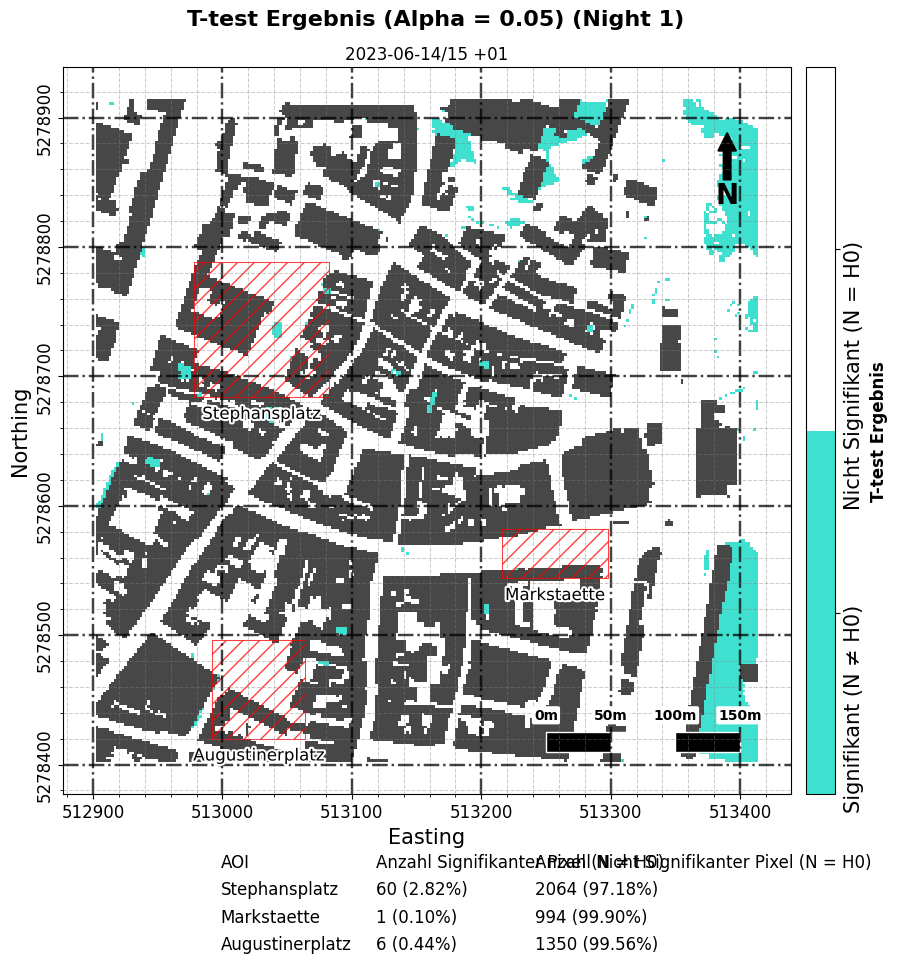

In [22]:
# Prepare lists of t-test result arrays for plotting (Night 1).
t_test_results_list_masked_night = [ma.array(t_test_results_night1, mask=~buildings_2d_data.mask)]

# Titles for the t-test result subplots.
list_of_titles_ttest_night = ['2023-06-14/15 +01']

# --- Plotting T-test Results for Night 1 ---
# Create a figure and a single subplot.
fig, axs = plt.subplots(1, 1, figsize=(19, 9), facecolor='w', edgecolor='k')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.rcParams.update({'font.size': 15})

# Set the main title for the t-test result plot.
fig.suptitle(f"T-test Ergebnis (Alpha = {alpha_test}) (Night 1)", fontsize=16, weight='bold')

# Directly assign axs for a single subplot.
ax = axs
variable_data = t_test_results_list_masked_night[0]
    
# Define a custom colormap for t-test results.
cmap = lsc.from_list("CustomCmap", ['#40E0D0', '#ffffff'], N=2)
cmap.set_bad('#474747')

# Plot the t-test result data.
pcm = ax.pcolormesh(x, y, variable_data, cmap=cmap, vmin=1, vmax=2)
    
# Extract raw values for statistics.
values = variable_data[:,:]
    
# Define buffer distance and plot buffered AOIs.
buffer_distance = 10
buffered_gdf = gdf_uhi.copy()
buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(buffer_distance, join_style=2)
buffered_gdf.plot(ax=ax, color='none', edgecolor='r', linewidth=0.75, alpha=0.75, hatch='//')

# Initialize lists to store counts of 'Reject null' (count_1) and 'Failed to reject null' (count_2) pixels.
count_1 = []
count_2 = []
count_sum = []

# Iterate through each AOI to compute pixel counts.
for index, row in gdf_uhi.iterrows():
    polygon = row.geometry
    min_x, min_y, max_x, max_y = polygon.bounds
    x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y)/dy), int((max_x-origin_x)/dx), int((max_y-origin_y)/dy)

    values_polygon = values[y1-buffer_distance:y2+buffer_distance, x1-buffer_distance:x2+buffer_distance]
    count_ones = np.sum(values_polygon == 1)
    count_twos = np.sum(values_polygon == 2)

    count_1.append(count_ones)
    count_2.append(count_twos)
    count_sum.append(count_ones + count_twos)
        
    # Annotate AOIs.
    ax.annotate(row['Location'], 
                xy=(polygon.centroid.x, min_y), 
                xytext=(0,-25), 
                textcoords="offset points", 
                ha='center', 
                fontsize=12,
                path_effects=[pe.withStroke(linewidth=3, foreground='white')])

# Configure grid, labels, and ticks.
ax.grid(True, linestyle='-.', linewidth=1.75, color='k', alpha=0.75)
ax.set_xlabel('Easting', fontsize=15)
ax.set_ylabel('Northing', fontsize=15)
ax.set_aspect(1)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax.yaxis.grid(which='minor', linestyle='--', linewidth=0.75, color='grey', alpha=0.4)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelrotation=90, labelsize=12)
center_yticks(ax)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y_val, pos: f'{y_val:.0f}'))
ax.set_title(f'{list_of_titles_ttest_night[0]}', fontsize=12)
ax.set_xlim(x[0]-25, x[-1]+25)
ax.set_ylim(y[0]-25, y[-1]+25)

# Create color bar for t-test results.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.15)
cb = fig.colorbar(pcm, cax=cax, extend=None, format='%.2f', spacing='uniform')
cb.ax.xaxis.set_ticks_position("top")
cb.ax.set_ylabel("T-test Ergebnis", fontsize=12, weight="bold")

# Set custom ticks and labels for the color bar.
custom_ticks = [1.25, 1.75]
custom_labels = ['Signifikant (N ≠ H0)', 'Nicht Signifikant (N = H0)'] 
cb.set_ticks(custom_ticks)
cb.set_ticklabels(custom_labels)
cb.ax.tick_params(rotation=90)

# Create a table summarizing t-test results.
table_data = [
    ["AOI", "Anzahl Signifikanter Pixel (N ≠ H0)", "Anzahl Nicht Signifikanter Pixel (N = H0)"], 
    [f"{location_name_list[1]}", f"{count_1[0]} ({(count_1[0]/count_sum[0])*100:.2f}%)", f"{count_2[0]} ({(count_2[0]/count_sum[0])*100:.2f}%)"],
    [f"{location_name_list[2]}", f"{count_1[1]} ({(count_1[1]/count_sum[1])*100:.2f}%)", f"{count_2[1]} ({(count_2[1]/count_sum[1])*100:.2f}%)"],
    [f"{location_name_list[3]}", f"{count_1[2]} ({(count_1[2]/count_sum[2])*100:.2f}%)", f"{count_2[2]} ({(count_2[2]/count_sum[2])*100:.2f}%)"],
]
table = ax.table(cellText=table_data,
                 loc='bottom',
                 cellLoc='left',
                 colWidths=[0.35, 0.35, 0.45],
                 edges='open',
                 bbox=[0.195, -0.225, 0.7, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(12)

plot_north_arrow_and_scale_bar(ax)
plt.show()